# Rolling Forecast or WFA >> Cross-Validation

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from datetime import datetime
import os
import pandas as pd
from copy import deepcopy
import backtrader as bt
import random

In [3]:
from _smac_strategy import SMAC
from _acct_value import AcctStats, AcctValue
from _position_sizing import PropSizer

In [4]:
# SET TIME PERIOD

In [5]:
start = datetime(2010,1,1)
end = datetime(2022,4,20)

In [6]:
# GET DATA

In [7]:
tickers_path = os.path.join(os.getenv("STOCK_DATA_PATH"),'OHLC_Yahoo','1D')

In [8]:
ticker_paths = [os.path.join(tickers_path,i) for i in os.listdir(tickers_path)]
tickers = [t.replace('.csv','') for t in os.listdir(tickers_path)]

In [9]:
datafeeds = {}
for ticker_path in ticker_paths:
    ticker = os.path.basename(ticker_path).replace('.csv','')
    df = pd.read_csv(ticker_path,parse_dates=True,index_col=0)
    df = df.loc[[x for x in df.index if start<=x<=end]]
    df['Close'] = df['Adj Close']
    df.drop("Adj Close",axis=1,inplace=True)
    df['OpenInterest'] = 0
    datafeeds[ticker] = deepcopy(df)

In [10]:
[len(datafeeds[t]) for t in datafeeds]

[3096, 3096, 3096, 3096, 3096, 3096, 3096, 3096, 3096, 3096, 3096]

In [11]:
# APPLY STATEGY

In [12]:
cerebro = bt.Cerebro(stdstats=False)

plot_symbols = ['SPY','AMZN','WFC']

is_first=True
for s,df in datafeeds.items():
    data = bt.feeds.PandasData(dataname=df,name=s)
    if s in plot_symbols:
        if is_first:
            data_main_plot = data
            is_first = False
        else:
            data.plotinfo.plotmaster = data_main_plot
    else:
        data.plotinfo.plot = False
    cerebro.adddata(data)

cerebro.broker.setcash(1000000)
cerebro.broker.setcommission(0.01)
cerebro.addstrategy(SMAC)
cerebro.addobserver(AcctValue)
cerebro.addobservermulti(bt.observers.BuySell) #Plotting Up/Down Arrows
cerebro.addsizer(PropSizer)
cerebro.addanalyzer(AcctStats)

cerebro.run()

<IPython.core.display.Javascript object>


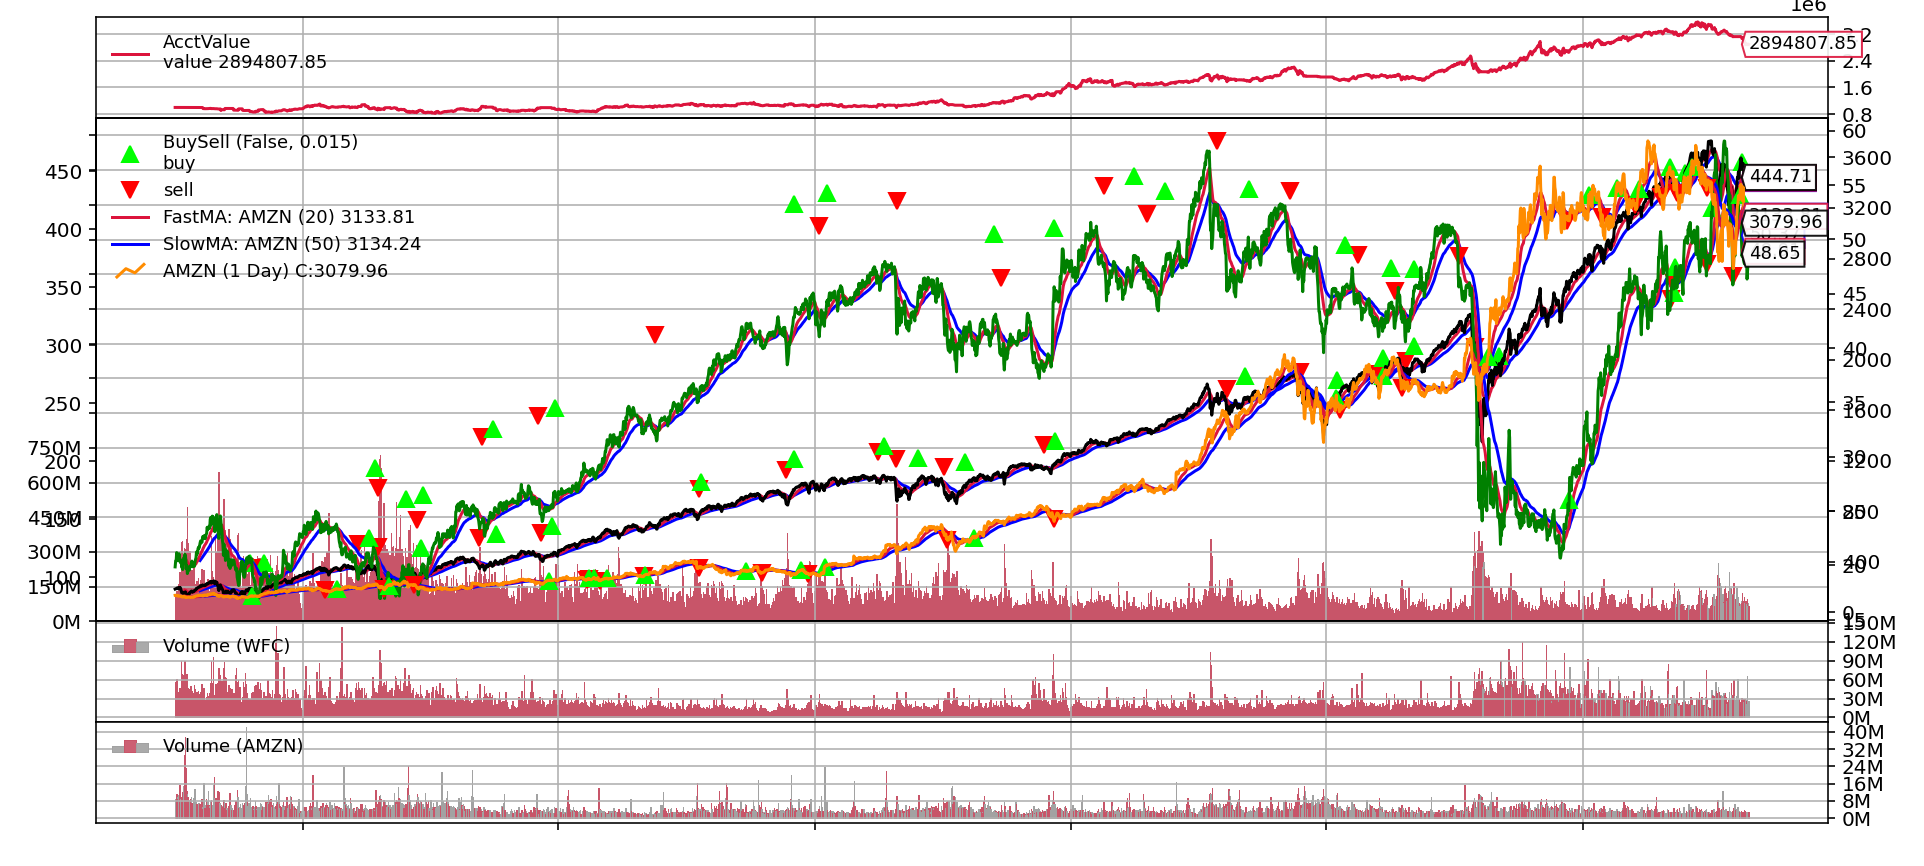

[[<Figure size 432x288 with 7 Axes>]]

In [13]:
cerebro.plot(iplot=True, volume=True)

In [15]:
from _data_prep import TimeSeriesSplitImproved

In [16]:
tscv = TimeSeriesSplitImproved(10)

In [18]:
split = tscv.split(datafeeds['AAPL'],fixed_length=True, train_splits=2)

In [21]:
windowset = set()
while len(windowset)<40:
    f = random.randint(1,10) *5
    s = random.randint(1,10) *5
    if f>s:
        f,s = s,f
        windowset.add((f,s))
windows = list(windowset)

In [40]:
from tqdm import tqdm

In [39]:
walk_forward_results = list()

for train,test in tqdm(split):
    # TRAINING
    windowset = set()
    while len(windowset)<40:
        f = random.randint(1,10) *5
        s = random.randint(1,10) *5
        if f>s:
            f,s = s,f
            windowset.add((f,s))
    windows = list(windowset)
    
    trainer = bt.Cerebro(stdstats=False,maxcpus=1)
    trainer.broker.setcash(1000000)
    trainer.broker.setcommission(0.01)
    trainer.addanalyzer(AcctStats)
    trainer.addsizer(PropSizer)
    
    tester = deepcopy(trainer)
    
    trainer.optstrategy(SMAC, optim=True, optim_fs=windows)
    
    for s,df in datafeeds.items():
        data = bt.feeds.PandasData(dataname=df.iloc[train],name=s)
        
        trainer.adddata(data)
        
    res = trainer.run()
    
    # Get Optimal combination
    opt_res = pd.DataFrame(
        {r[0].params.optim_fs:r[0].analyzers.acctstats.get_analysis() for r in res}
    ).T.loc[:,'return'].sort_values(ascending=False).index[0]
    
    # TESTING
    tester.addstrategy(SMAC, optim=True, optim_fs=opt_res)
    for s,df in datafeeds.items():
        data = bt.feeds.PandasData(dataname=df.iloc[test],name=s)
        tester.adddata(data)
    
    res = tester.run()
    res_dict = res[0].analyzers.acctstats.get_analysis()
    res_dict['fast'],res_dict['slow'] = opt_res
    res_dict['start_date'] = datafeeds['AAPL'].iloc[test[0]].name
    res_dict['end_data'] = datafeeds['AAPL'].iloc[test[-1]].name
    walk_forward_results.append(res_dict)


NameError: name 'walk_forward_results' is not defined

In [ ]:
wfdf = pd.DataFrame(walk_forward_results)
wfdf